In [898]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [899]:
inputdata1 = "../output_combined/" 
outputdata1 = "../output_mo/regressiondata_mo/"

extended_data_monthly = "a0_combinedMonthly_extended_ARIMA.csv"
extended_data_quarterly = "a0_combinedQuarterly_extended_ARIMA.csv"

extended_data_monthly = "a0_combinedMonthly_extended_ETS.csv"
extended_data_quarterly = "a0_combinedQuarterly_extended_ETS.csv"
#extended_data2 = "a0_combinedMonthly_extended_ETS.csv"

In [900]:
def x_data():
    x_data = pd.read_csv(inputdata1 + extended_data_monthly, index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date

    # R doesn't like columns with special characters
    x_data.columns = x_data.columns.str.replace("X.", "^", regex=True)
    x_data.columns = x_data.columns.str.replace(".", " ", regex=False)
    x_data.columns = x_data.columns.str.replace("  ", ", ", regex=False)
    print(x_data.columns.tolist())

    return x_data

x_data().head()

['^AEX', 'ASML AS', 'AIR', 'ING', 'WKL AS', 'STLA', 'AD AS', 'PHG', '^FVX', '^TNX', '^TYX', '^VIX', 'Bankruptcies', 'BusinessOutlook_Industry', 'BusinessOutlook_Retail', 'Consumentenvertrouwen_1', 'EconomischKlimaat_2', 'Koopbereidheid_3', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'CPIAfgeleid_2', 'MaandmutatieCPI_3', 'MaandmutatieCPIAfgeleid_4', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Crude oil, average', 'Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI', 'Coal, Australian', 'Coal, South African,  ', 'Natural gas, US', 'Natural gas, Europe', 'Liquefied natural gas, Japan', 'Natural gas index', 'Cocoa', 'Coffee, Arabica', 'Coffee, Robusta', 'Tea, avg 3 auctions', 'Tea, Colombo', 'Tea, Kolkata', 'Tea, Mombasa', 'Coconut oil', 'Groundnuts', 'Fish meal', 'Groundnut oil,  ', 'Palm oil', 'Palm kernel oil', 'Soybeans

,^AEX,ASML AS,AIR,ING,WKL AS,STLA,AD AS,PHG,^FVX,^TNX,...,Italy_unemply_F,Italy_unemply_M,Spain_unemply_F,Spain_unemply_M,Belgium_unemply_F,Belgium_unemply_M,Japan_unemply_F,Japan_unemply_M,United States_unemply_F,United States_unemply_M
1995-01-01,187.171368,NaN,6.981738,3.254189,NaN,NaN,NaN,3.909096,7.741667,7.761238,...,15.4,8.7,28.9,16.9,12.6,7.6,3.0,2.9,5.6,5.6
1995-02-01,186.834868,NaN,7.055271,3.319502,NaN,NaN,NaN,4.089017,7.357895,7.457158,...,15.4,8.7,28.6,16.7,12.6,7.6,3.0,2.9,5.5,5.4
1995-03-01,179.719088,NaN,6.749855,3.387885,6.580569,NaN,NaN,4.233587,7.037478,7.192174,...,15.5,8.8,28.2,16.4,12.6,7.6,3.2,3.0,5.5,5.3
1995-04-01,184.062915,NaN,6.915176,3.580347,6.756925,NaN,NaN,4.432653,6.845158,7.043947,...,15.3,8.5,27.7,16.3,12.6,7.5,3.1,3.1,5.9,5.6
1995-05-01,193.378887,NaN,7.321506,3.789410,7.071823,NaN,NaN,4.931614,6.406045,6.618227,...,15.3,8.5,27.6,16.3,12.6,7.5,3.1,2.9,5.5,5.8


### Change quarterly data to monthly using smoothing

In [901]:
def y_data(seasonal=True):
    if seasonal:
        y_data = pd.read_csv(inputdata1 + extended_data_quarterly, parse_dates=[0], index_col=0)['gdp_total_deseasonalized'].to_frame()
    else:
        y_data = pd.read_csv(inputdata1 + extended_data_quarterly, parse_dates=[0], index_col=0)['gdp_total'].to_frame()

    upsampled = y_data.resample('MS')
    y_data = upsampled.interpolate(method='spline', order=2)

    return y_data


### Combine Y and X data

In [902]:
regressionData = y_data(seasonal=True).merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")

start_date_analysis = "2000-08-01"  # make divisible by 12 to make coding easier
save_some_data_for_predictions = "2024-07-01"
df1 = regressionData.loc[start_date_analysis:save_some_data_for_predictions,:].copy()

df1.columns

['^AEX', 'ASML AS', 'AIR', 'ING', 'WKL AS', 'STLA', 'AD AS', 'PHG', '^FVX', '^TNX', '^TYX', '^VIX', 'Bankruptcies', 'BusinessOutlook_Industry', 'BusinessOutlook_Retail', 'Consumentenvertrouwen_1', 'EconomischKlimaat_2', 'Koopbereidheid_3', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'CPIAfgeleid_2', 'MaandmutatieCPI_3', 'MaandmutatieCPIAfgeleid_4', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Crude oil, average', 'Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI', 'Coal, Australian', 'Coal, South African,  ', 'Natural gas, US', 'Natural gas, Europe', 'Liquefied natural gas, Japan', 'Natural gas index', 'Cocoa', 'Coffee, Arabica', 'Coffee, Robusta', 'Tea, avg 3 auctions', 'Tea, Colombo', 'Tea, Kolkata', 'Tea, Mombasa', 'Coconut oil', 'Groundnuts', 'Fish meal', 'Groundnut oil,  ', 'Palm oil', 'Palm kernel oil', 'Soybeans

Index(['gdp_total_deseasonalized', '^AEX', 'ASML AS', 'AIR', 'ING', 'WKL AS',
       'STLA', 'AD AS', 'PHG', '^FVX',
       ...
       'Italy_unemply_F', 'Italy_unemply_M', 'Spain_unemply_F',
       'Spain_unemply_M', 'Belgium_unemply_F', 'Belgium_unemply_M',
       'Japan_unemply_F', 'Japan_unemply_M', 'United States_unemply_F',
       'United States_unemply_M'],
      dtype='object', length=143)

### Save transformations of GDP

In [903]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))


GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()


In [904]:
# subset of the data
df1 = df1[['gdp_total', 
          '^AEX', 
          '^FVX',
          '^TNX',
          '^TYX',
          '^VIX',

          'Bankruptcies',
          'Consumentenvertrouwen_1',
          'EconomischKlimaat_2',
          'Koopbereidheid_3',
          'EconomischeSituatieLaatste12Maanden_4',
          'EconomischeSituatieKomende12Maanden_5',
          'FinancieleSituatieLaatste12Maanden_6',
          'FinancieleSituatieKomende12Maanden_7',
          'GunstigeTijdVoorGroteAankopen_8',
          'CPI_1',
          'MaandmutatieCPI_3',
          'ProducerConfidence_1', 
          'ExpectedActivity_2',

          'Crude oil, Brent',
          'Coal, Australian',
          'Natural gas, Europe', 
          'Natural gas index',

          'Gold', 
          'Platinum',
          'M3_1', 
          # 'M3_2',
          # 'M1',

          'BE_Inflation',
          'EE_Inflation',
          'NL_Inflation',

          
          'CCICP_NLD_CLI', 
          'BCICP_NLD_CLI',
          'BCICP_DEU',

          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
           
          'United States_unemply_F',
          'United States_unemply_M', 
          
        ]]


### Drop if number of observations less than GDP

In [905]:

def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)
df1

[]


,gdp_total,^AEX,^FVX,^TNX,^TYX,^VIX,Bankruptcies,Consumentenvertrouwen_1,EconomischKlimaat_2,Koopbereidheid_3,...,BE_Inflation,EE_Inflation,NL_Inflation,CCICP_NLD_CLI,BCICP_NLD_CLI,BCICP_DEU,Netherlands_unemply_F,Netherlands_unemply_M,United States_unemply_F,United States_unemply_M
2000-08-01,166653.479750,686.172175,6.050304,5.820391,5.710565,18.088696,452.0,31.0,33.0,30.0,...,3.5,4.4,2.5,102.09570,101.5040,100.98630,4.9,2.5,4.3,3.9
2000-09-01,167299.150314,674.714762,5.914000,5.788050,5.819200,19.687500,354.0,30.0,30.0,30.0,...,4.0,4.7,2.9,102.13650,101.4734,100.99670,4.8,2.5,4.0,3.9
2000-10-01,167805.000000,659.090454,5.766818,5.735000,5.801091,25.200000,440.0,32.0,32.0,31.0,...,3.7,5.4,3.2,102.20640,101.4700,100.98880,4.8,2.4,3.9,3.9
2000-11-01,168175.708986,672.587724,5.687381,5.702333,5.767952,26.382857,495.0,30.0,29.0,30.0,...,3.7,5.7,2.9,102.13510,101.4057,100.92470,4.7,2.4,4.0,3.9
2000-12-01,168405.657848,644.169993,5.156150,5.228450,5.486500,26.530500,360.0,31.0,29.0,32.0,...,3.0,5.0,2.9,101.92100,101.2714,100.80090,4.6,2.3,3.8,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,234863.391063,863.843002,4.201850,4.208100,4.362250,13.787500,345.0,-22.0,-35.0,-14.0,...,3.8,4.1,3.1,99.40694,100.0772,98.83055,3.8,3.5,3.9,3.7
2024-04-01,235834.000000,877.564285,4.558182,4.538318,4.656955,16.137727,427.0,-21.0,-34.0,-13.0,...,4.9,3.1,2.6,99.38541,100.1734,98.79703,3.8,3.6,3.8,3.9
2024-05-01,236623.140186,906.555914,4.499955,4.481955,4.618364,13.090455,343.0,-22.0,-38.0,-12.0,...,4.9,3.1,2.7,99.36152,100.2592,98.79351,3.7,3.5,3.7,4.2
2024-06-01,237285.046668,922.693997,4.318842,4.305105,4.445632,12.676842,377.0,-23.0,-38.0,-14.0,...,5.4,2.8,3.4,99.37430,100.2941,98.75754,3.8,3.5,4.0,4.1


### Add 'sure' data and random data

In [906]:
# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

# trend
df1['trend'] = [i for i in range(0, len(df1))]

### Standard Scaler

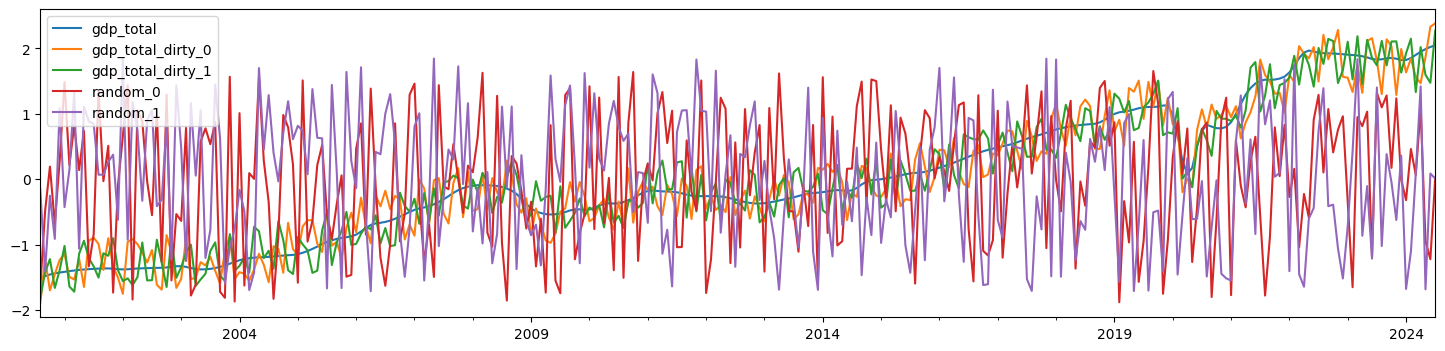

In [907]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]

In [908]:
# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   

In [909]:
def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

In [910]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [911]:
def seasonality_test(data):
    kw_test1 = data.loc[start_date_analysis:save_some_data_for_predictions,:]
    kw_test1['Months'] = [1,2,3,4,5,6,7,8,9,10,11,12] * int(len(kw_test1)/12)
    kw_test1['Semi'] = [1,2,3,4,5,6] * int(len(kw_test1)/6)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

In [912]:
def Kruskal_Wallis_Monthly(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Months'].unique():
            res.append(data[data['Months'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Monthly_Seasonality'] = 'No_Monthly_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Monthly_Seasonality'] = 'Monthly_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Monthly(kw1, STORE_FOR_TESTS)

In [913]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [914]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
# Causing loss of data!!!
#scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    print(i)
    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=12, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.to_csv("tmp_scaled_features_df.csv ")

MaandmutatieCPI_3


[ 0  2  4  6  9 14 17 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 39]
['^AEX', '^TNX', '^VIX', 'Consumentenvertrouwen_1', 'EconomischeSituatieLaatste12Maanden_4', 'CPI_1', 'ExpectedActivity_2', 'Natural gas, Europe', 'Natural gas index', 'Gold', 'Platinum', 'M3_1', 'BE_Inflation', 'EE_Inflation', 'NL_Inflation', 'CCICP_NLD_CLI', 'BCICP_NLD_CLI', 'BCICP_DEU', 'Netherlands_unemply_F', 'Netherlands_unemply_M', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'trend']


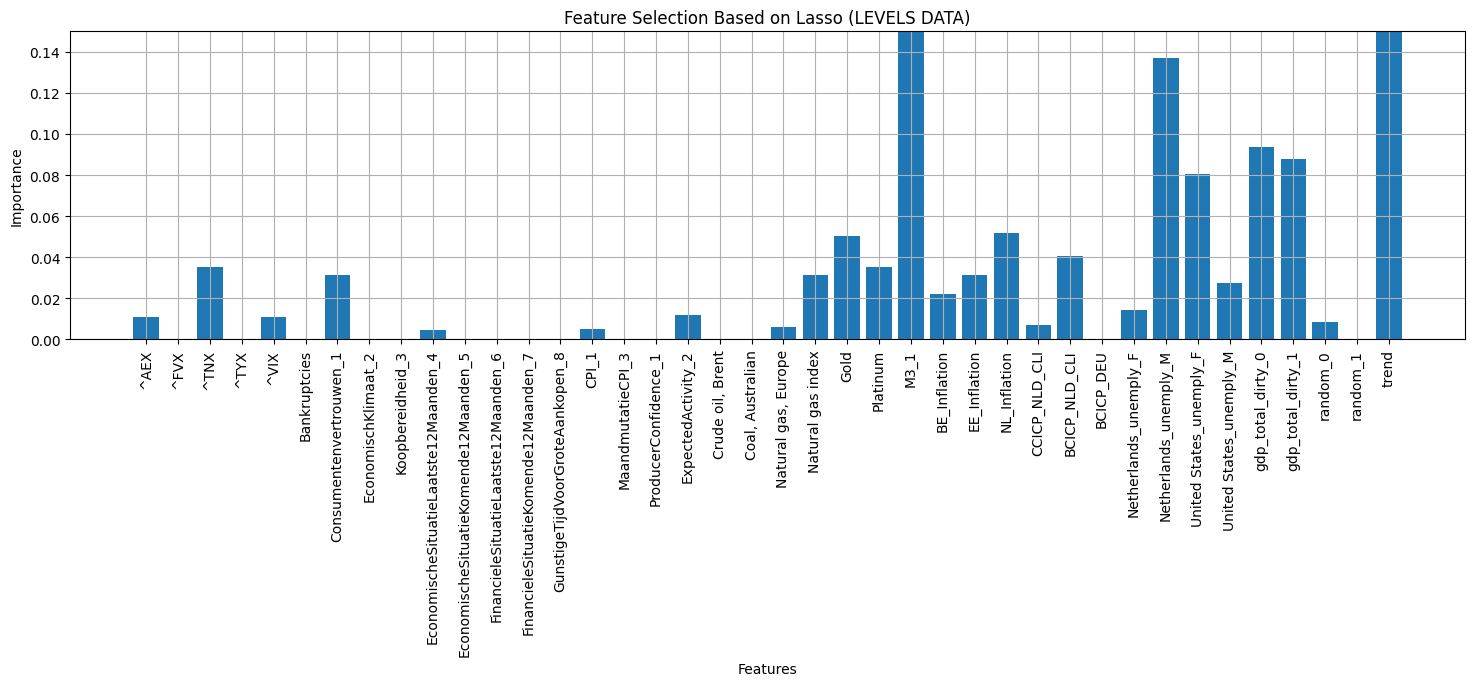

(288, 41)


In [915]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.001, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  3  4  5  9 10 11 12 13 14 15 16 17 19 21 23 24 25 26 27 29 30 32 33
 34 35 36 37 38 39]
['^AEX', '^TYX', '^VIX', 'Bankruptcies', 'EconomischeSituatieLaatste12Maanden_4', 'EconomischeSituatieKomende12Maanden_5', 'FinancieleSituatieLaatste12Maanden_6', 'FinancieleSituatieKomende12Maanden_7', 'GunstigeTijdVoorGroteAankopen_8', 'CPI_1', 'MaandmutatieCPI_3', 'ProducerConfidence_1', 'ExpectedActivity_2', 'Coal, Australian', 'Natural gas index', 'Platinum', 'M3_1', 'BE_Inflation', 'EE_Inflation', 'NL_Inflation', 'BCICP_NLD_CLI', 'BCICP_DEU', 'Netherlands_unemply_M', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'trend']


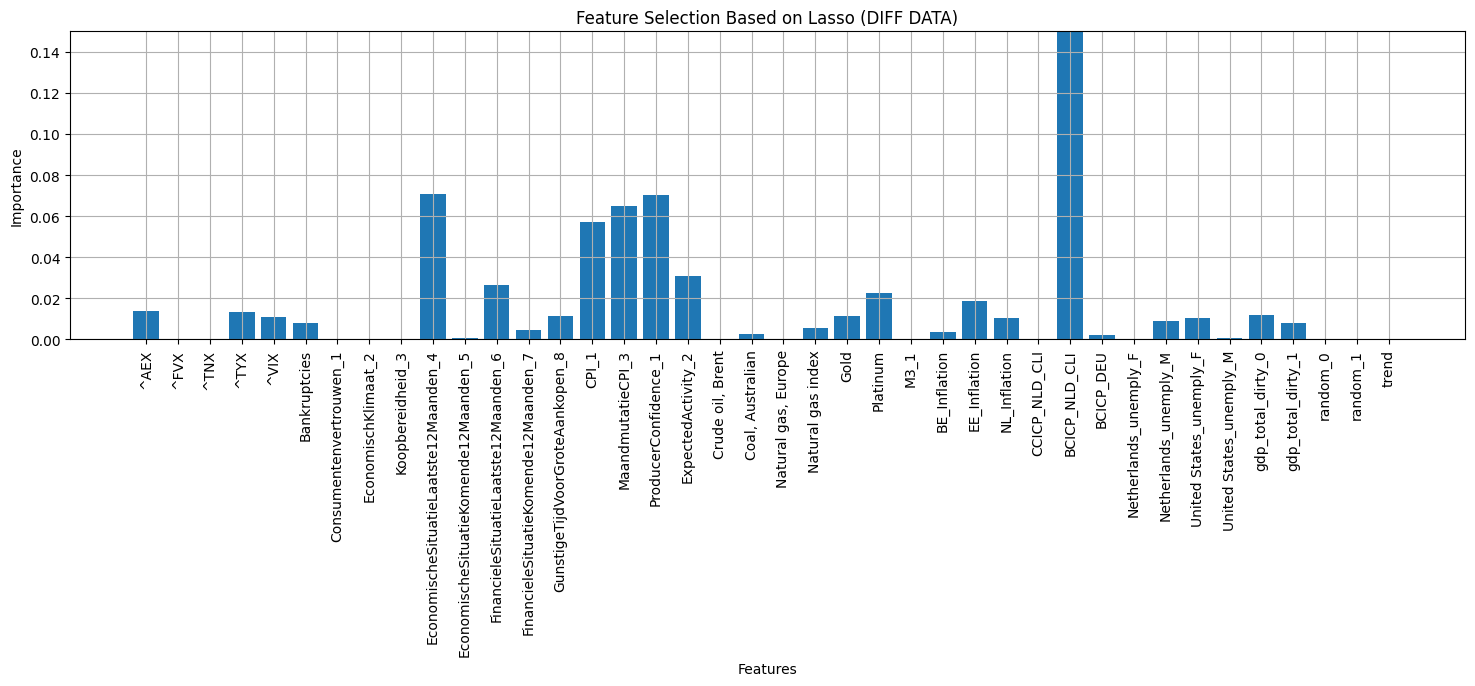

In [916]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (DIFF DATA)'); 

In [917]:
def lag_data(data):
    # only returns lags of variables, not original data
    df1 = data.copy()
    number_lags = 1

    for lag in range(1, number_lags+1):
        for col in df1.columns:
            df1[col + '_lag_' + str(lag)] = df1[col].shift(lag)
        
    selectThese = [col for col in df1.columns if '_lag_' in col]
    df_lag = df1[selectThese]

    return df_lag

df_lag  = lag_data(scaled_features_df)
df_lag.insert(loc=0, column='gdp_total', value=scaled_features_df['gdp_total'])

[ 0  1  2  4  5  6  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28
 30 31 32 33 34 35 36 38 39 40]
['gdp_total_lag_1', '^AEX_lag_1', '^FVX_lag_1', '^TYX_lag_1', '^VIX_lag_1', 'Bankruptcies_lag_1', 'Koopbereidheid_3_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'MaandmutatieCPI_3_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Coal, Australian_lag_1', 'Natural gas, Europe_lag_1', 'Natural gas index_lag_1', 'Gold_lag_1', 'Platinum_lag_1', 'M3_1_lag_1', 'EE_Inflation_lag_1', 'NL_Inflation_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_F_lag_1', 'United States_unemply_M_lag_1', 'gdp_total_dirty_0_lag_1', 'random_0_lag_1', 'random_1_lag_1', 'trend_lag_1']


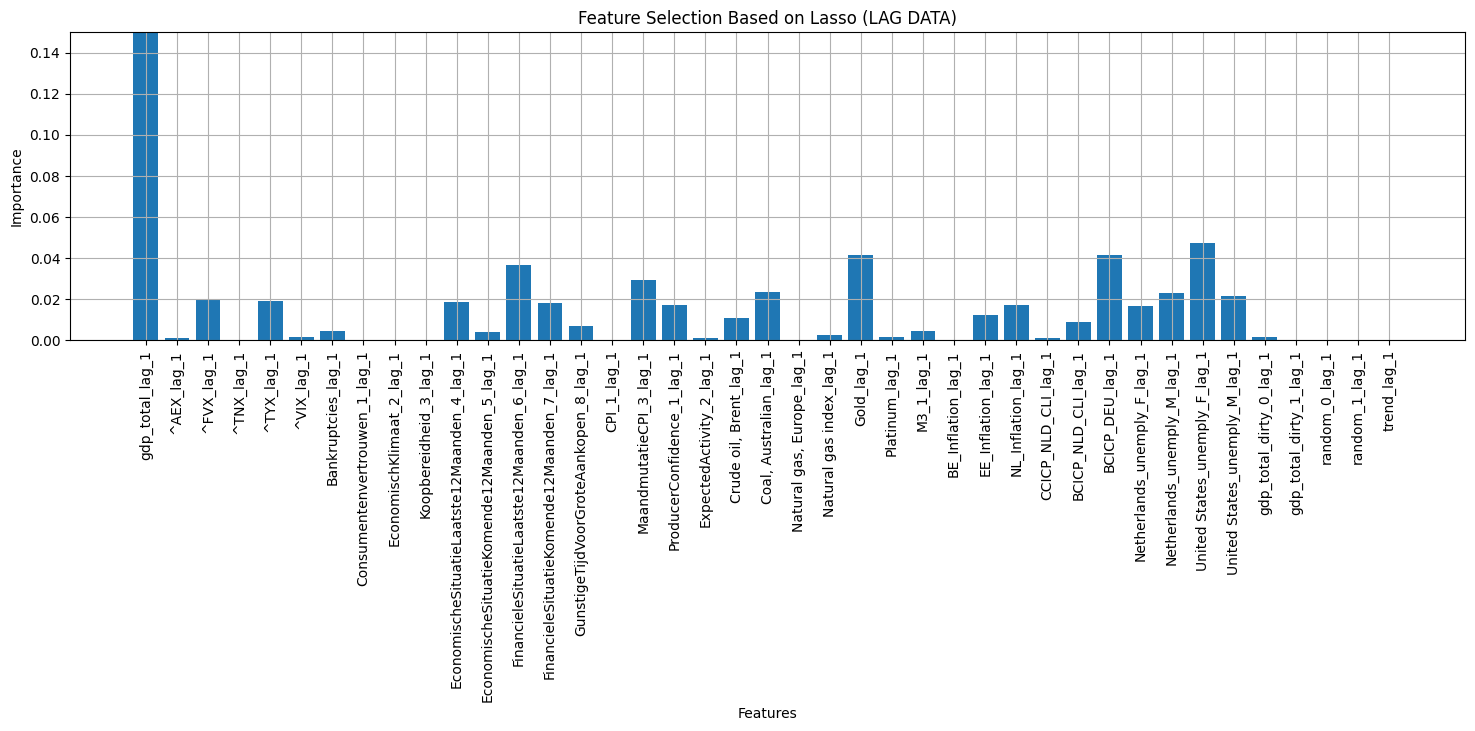

In [918]:
lassoreg(df_lag, alpha=0.0001, title='Feature Selection Based on Lasso (LAG DATA)'); 

[ 0  4  5  6 10 11 12 13 14 17 18 19 20 24 25 27 28 30 31 33 34 36 37 38
 39]
['gdp_total_lag_1', '^TYX_lag_1', '^VIX_lag_1', 'Bankruptcies_lag_1', 'EconomischeSituatieLaatste12Maanden_4_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'FinancieleSituatieLaatste12Maanden_6_lag_1', 'FinancieleSituatieKomende12Maanden_7_lag_1', 'GunstigeTijdVoorGroteAankopen_8_lag_1', 'ProducerConfidence_1_lag_1', 'ExpectedActivity_2_lag_1', 'Crude oil, Brent_lag_1', 'Coal, Australian_lag_1', 'Platinum_lag_1', 'M3_1_lag_1', 'EE_Inflation_lag_1', 'NL_Inflation_lag_1', 'BCICP_NLD_CLI_lag_1', 'BCICP_DEU_lag_1', 'Netherlands_unemply_M_lag_1', 'United States_unemply_F_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']


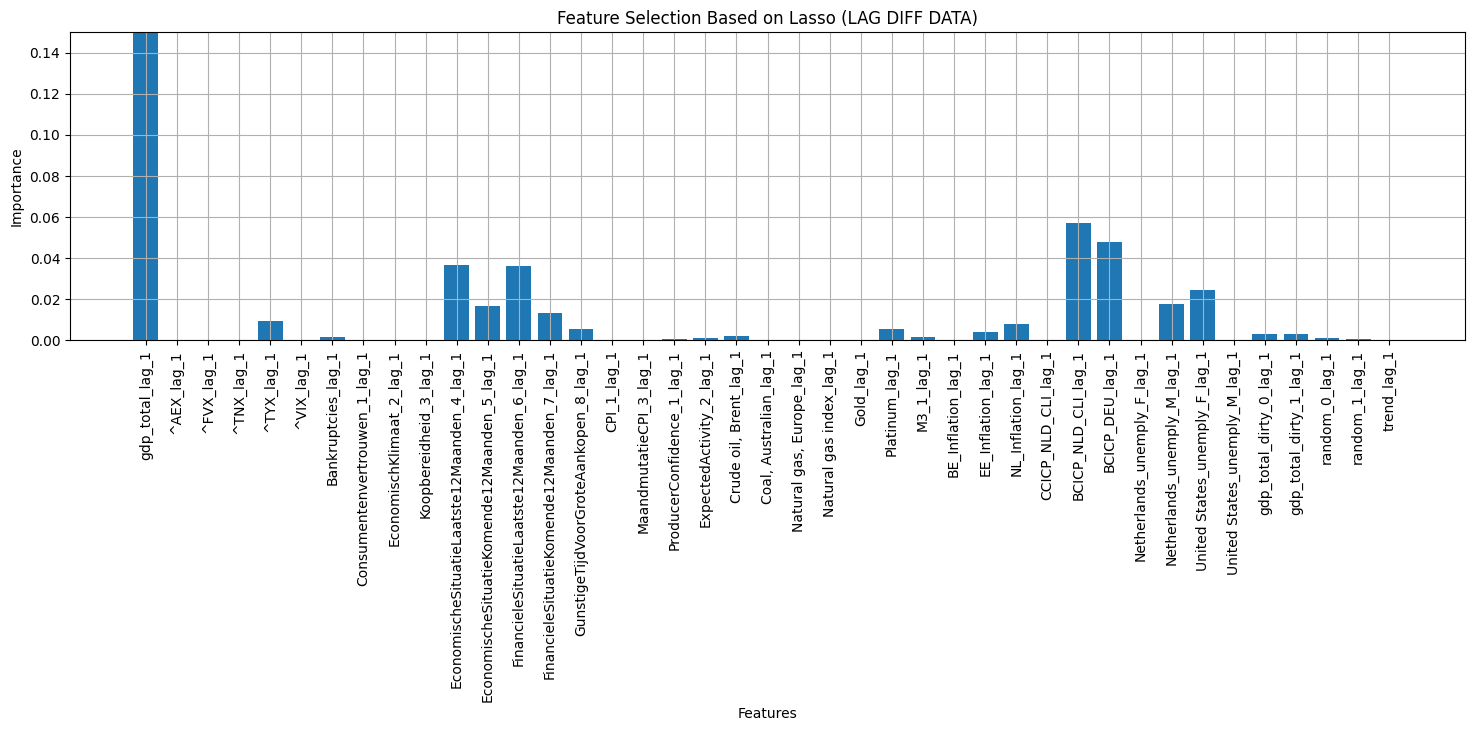

In [919]:
lassoreg(df_lag.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (LAG DIFF DATA)'); 


### Make sure data is stationary

In [920]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)

(41, 3)


### If not stationary, difference, then test for stationarity again

In [921]:
def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]


In [922]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NotStationary,NotStationary,True,No_Monthly_Seasonality
^FVX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TNX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^TYX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^VIX,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
Bankruptcies,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
EconomischKlimaat_2,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Koopbereidheid_3,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality


<Axes: >

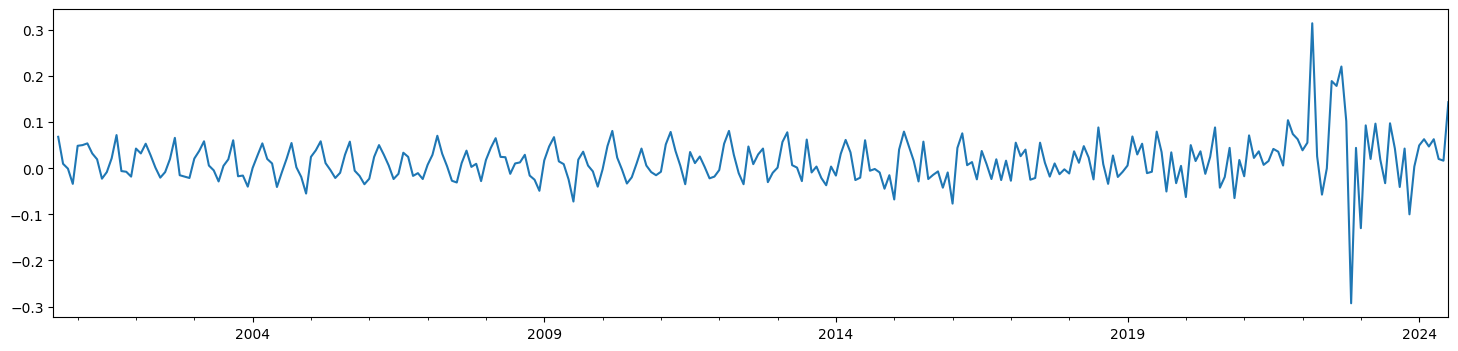

In [923]:
scaled_features_df_diff['CPI_1'].plot()

[ 0  2  3  4  9 11 13 17 18 26 28 30 33 34 35 36 38]
['^AEX', '^TNX', '^TYX', '^VIX', 'EconomischeSituatieLaatste12Maanden_4', 'FinancieleSituatieLaatste12Maanden_6', 'GunstigeTijdVoorGroteAankopen_8', 'ExpectedActivity_2', 'Crude oil, Brent', 'EE_Inflation', 'CCICP_NLD_CLI', 'BCICP_DEU', 'United States_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1']


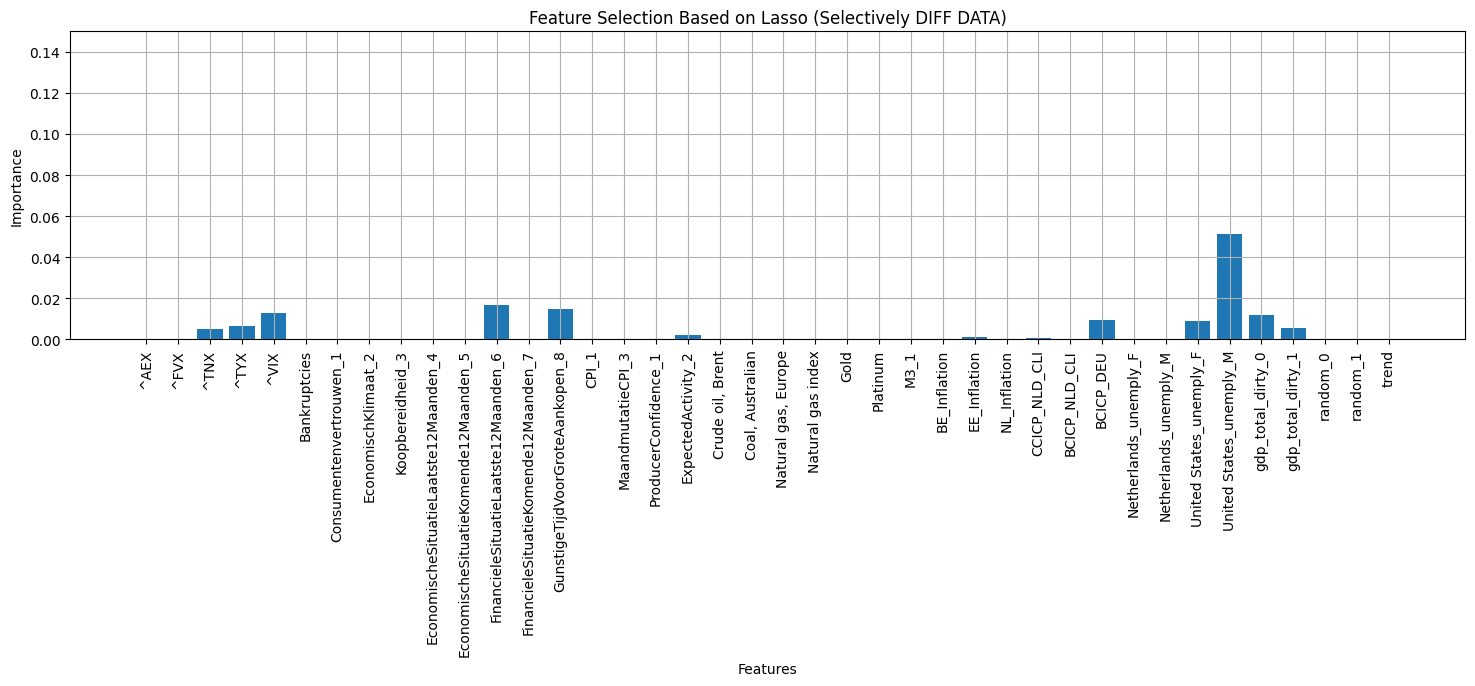

['^AEX',
 '^TNX',
 '^TYX',
 '^VIX',
 'EconomischeSituatieLaatste12Maanden_4',
 'FinancieleSituatieLaatste12Maanden_6',
 'GunstigeTijdVoorGroteAankopen_8',
 'ExpectedActivity_2',
 'Crude oil, Brent',
 'EE_Inflation',
 'CCICP_NLD_CLI',
 'BCICP_DEU',
 'United States_unemply_F',
 'United States_unemply_M',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_1']

In [924]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

<Axes: >

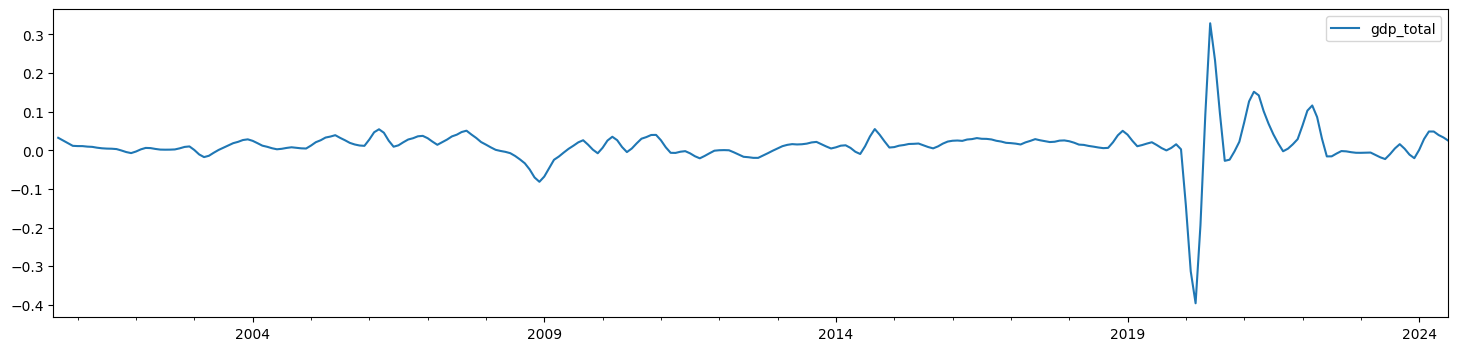

In [925]:
scaled_features_df_diff[['gdp_total']].plot()

In [926]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(288, 82)


In [927]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

In [928]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(288, 38)


[ 5 31 34]
['^VIX_lag_1', 'BCICP_DEU_lag_1', 'United States_unemply_F_lag_1']


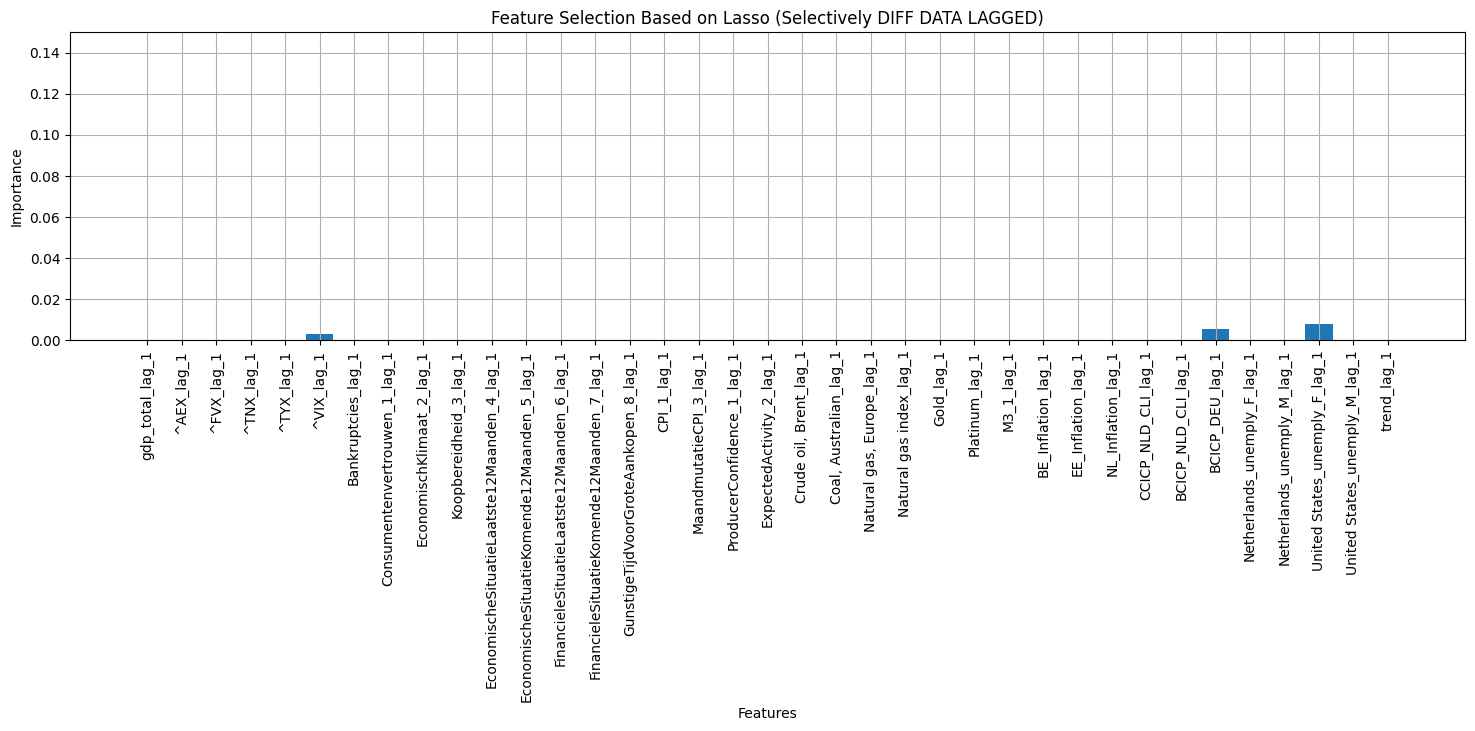

In [929]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.005, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

,gdp_total,^VIX_lag_1,BCICP_DEU_lag_1,United States_unemply_F_lag_1
2000-08-01,NaN,NaN,NaN,NaN
2000-09-01,0.032321,-0.211583,0.385354,-0.686464
2000-10-01,0.025322,-0.016320,0.392608,-0.849539
2000-11-01,0.018557,0.656926,0.387098,-0.903898
2000-12-01,0.011511,0.801390,0.342386,-0.849539
...,...,...,...,...
2024-03-01,0.048631,-0.717779,-1.095695,-0.903898
2024-04-01,0.048586,-0.736892,-1.118344,-0.903898
2024-05-01,0.039503,-0.449857,-1.141725,-0.958256
2024-06-01,0.033133,-0.822023,-1.144180,-1.012614


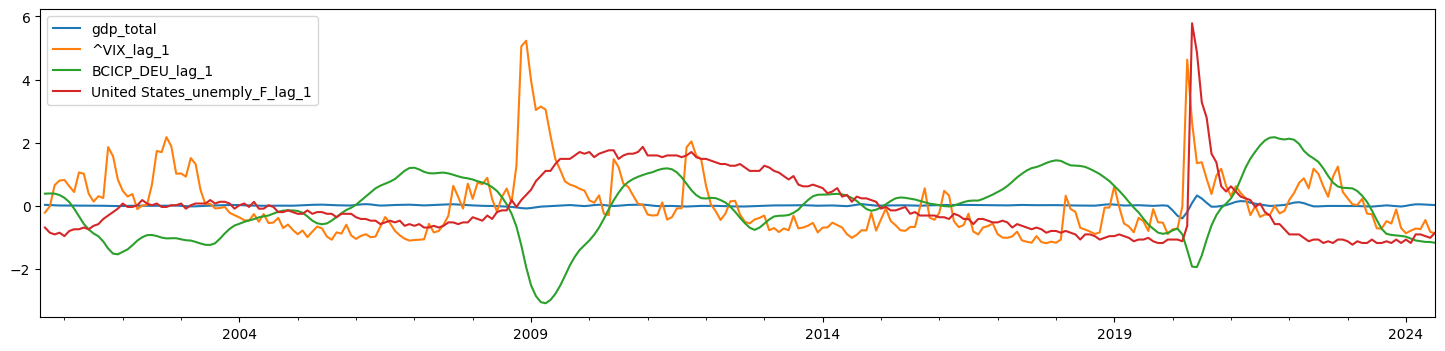

In [930]:
chooseThese = ['gdp_total'] + lasout
scaled_features_df_diff_lag[chooseThese].plot()
scaled_features_df_diff_lag[chooseThese]

<Axes: >

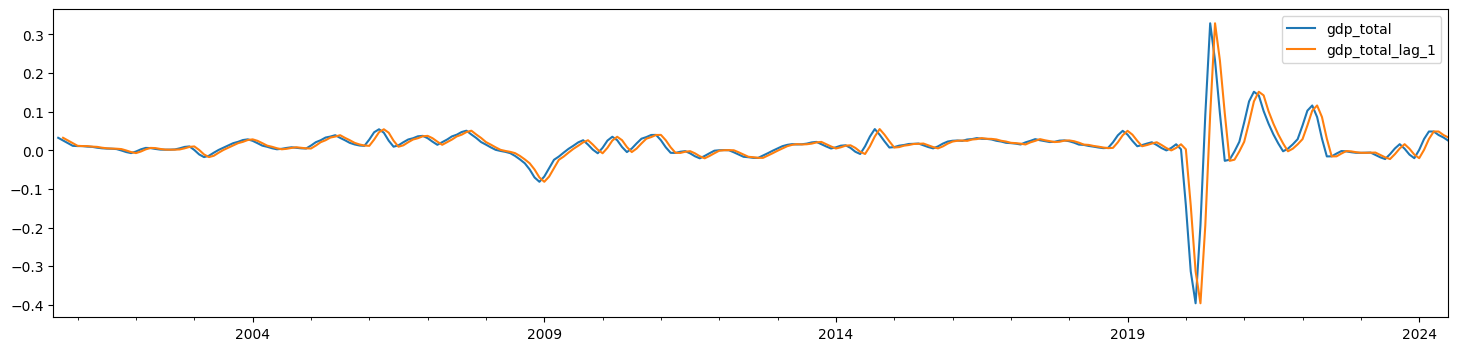

In [931]:
scaled_features_df_diff_lag[['gdp_total','gdp_total_lag_1']].plot()

In [932]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")

reg1.dropna(inplace=True)

##################################
test_start_date = start_date_analysis
end_test_date = '2023-03-01'
##################################

X = reg1.loc[test_start_date:end_test_date, chooseThese[1]:]
X = sm.add_constant(X)

y_true = reg1.loc[test_start_date:end_test_date:, 'gdp_total']

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     15.32
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           3.15e-09
Time:                        12:24:32   Log-Likelihood:                 446.52
No. Observations:                 271   AIC:                            -885.0
Df Residuals:                     267   BIC:                            -870.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<Axes: >

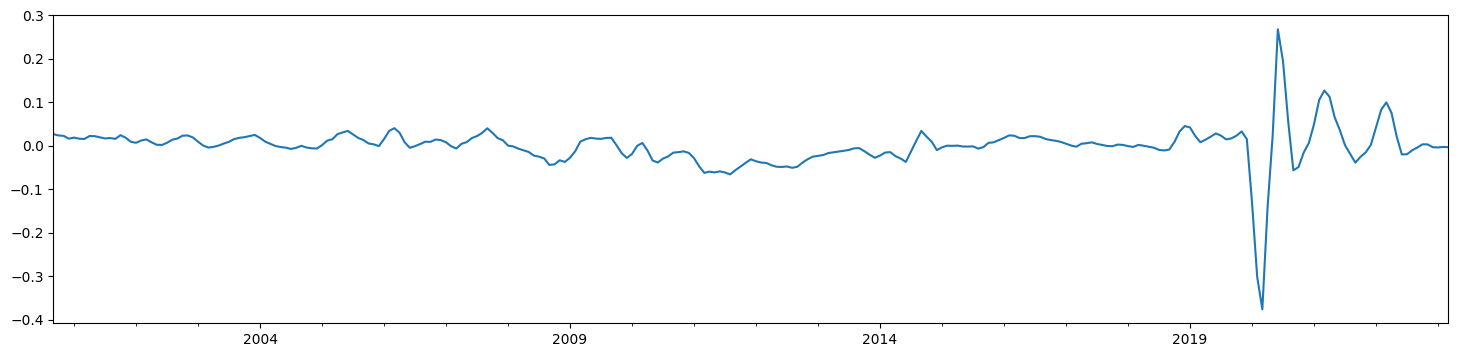

In [933]:
results.resid.plot()

<Axes: >

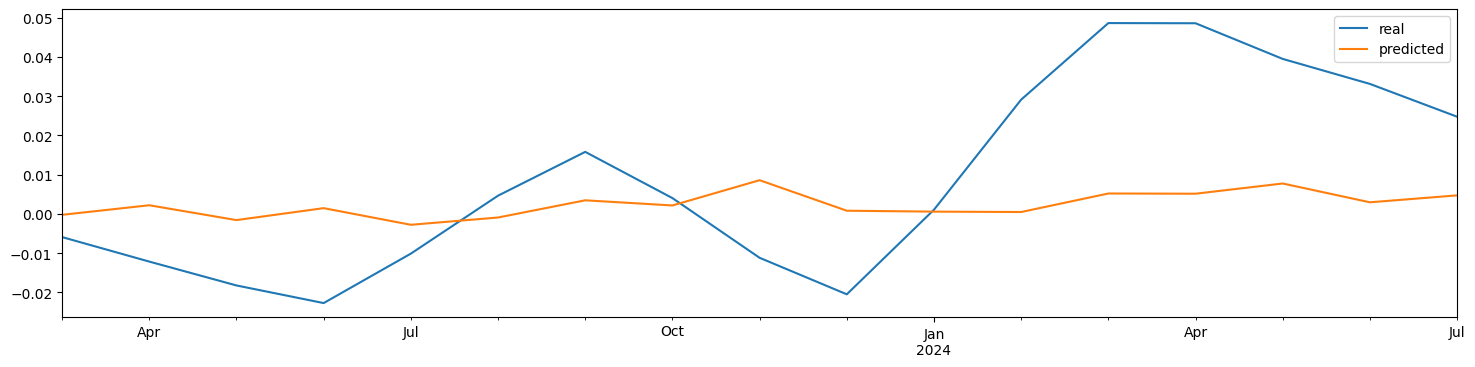

In [934]:
ypred = results.predict(X)
Xnew = reg1.loc[end_test_date:, chooseThese[1]:]
Xnew[['const']] = 1
reg1.loc[end_test_date:, ['gdp_total']]

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.loc[end_test_date:, 'gdp_total'], 'predicted': ynewpred})
df_pred.plot()


Heteroskedasticity (Breusch-Pagan)


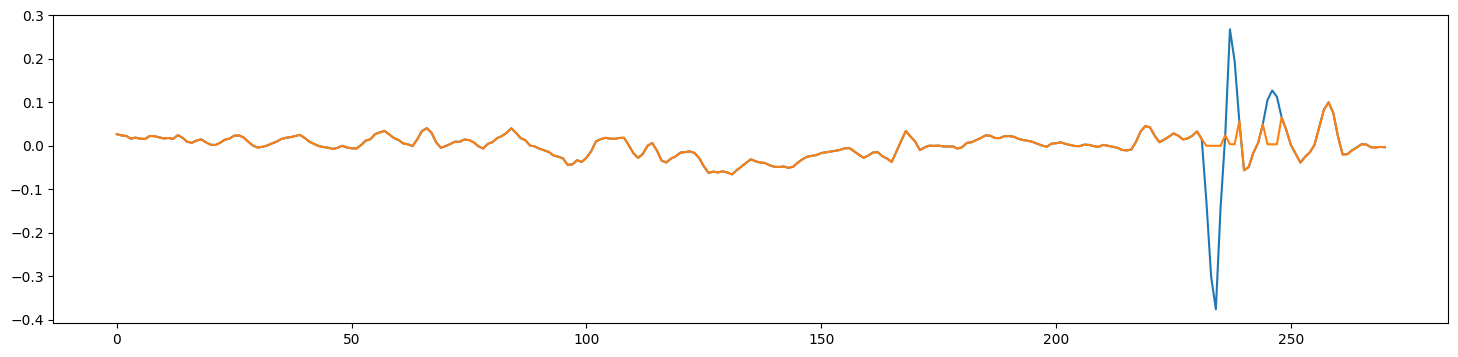

In [935]:

plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Remove Covid for tests
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Homoskedasticity
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

In [936]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Colinearity

In [937]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

0.31765411578808167
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


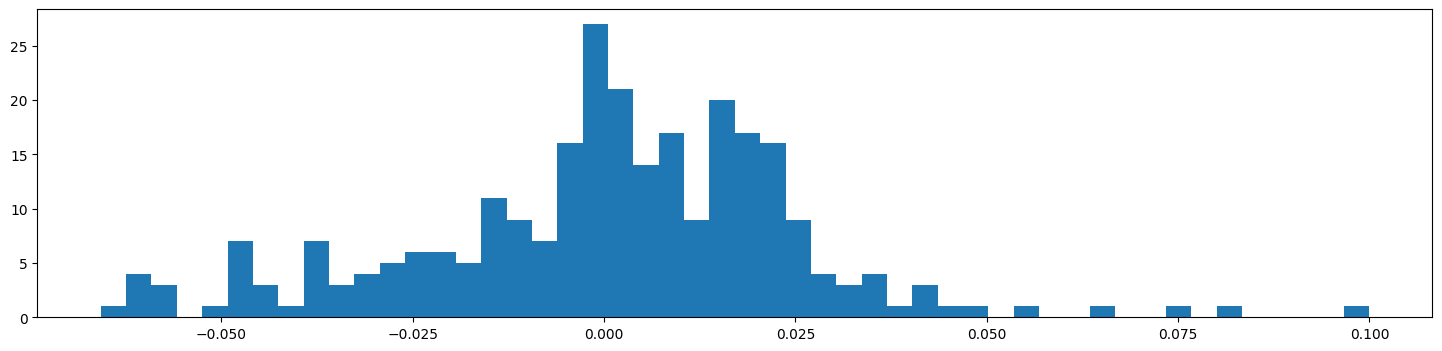

In [938]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

In [939]:

def test_reverse_transform(start_date_analysis, my_data_to_untransform):

    GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
    GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

    def diff_inv_Transformation(df_diff, first_value):
        series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
        return series_inverted

    def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
        return data * std + mean


    data_to_untransform = my_data_to_untransform
    date_start_difference = pd.to_datetime(start_date_analysis) + relativedelta(months=1)

    test1 = std_inv_Transformation(diff_inv_Transformation(data_to_untransform, GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']))

    return test1

tes1 = test_reverse_transform(start_date_analysis, y_true)
tes1


array([167299.15031357, 167944.82087722, 168450.67056364, 168821.37954983,
       169051.32841201, 169268.67056364, 169484.46329736, 169673.94378888,
       169850.67056364, 169984.19571402, 170087.36540052, 170174.67056364,
       170255.89969463, 170317.98217634, 170307.67056364, 170215.33213079,
       170069.97153541, 170005.67056364, 170052.92198938, 170175.52269987,
       170288.67056364, 170358.03000167, 170393.87553694, 170424.67056364,
       170457.79472415, 170501.5030017 , 170602.67056364, 170776.5819477 ,
       170976.35885659, 170992.67056364, 170778.08177003, 170425.8328384 ,
       170140.67056364, 170013.80233433, 170031.45414098, 170165.67056364,
       170420.36059568, 170788.17262577, 171224.67056364, 171754.72973762,
       172320.33471121, 172809.67056364, 173177.35056568, 173416.69750672,
       173596.67056364, 173701.79649276, 173753.56602883, 173830.67056364,
       173952.94423797, 174108.25959862, 174236.67056364, 174337.59564479,
       174429.19329211, 1

<Axes: >

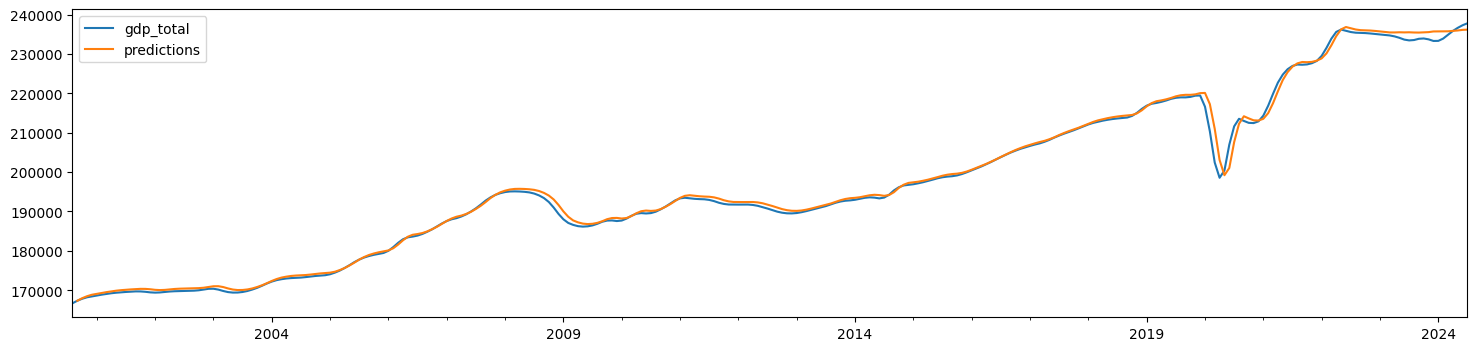

In [943]:
# create new column with existing data from gdp_total_scaled_diff, then replace with predictions values
GDP_TRANSFORMATIONS["predicts_before_transformations"] = GDP_TRANSFORMATIONS['gdp_total_scaled_diff']
GDP_TRANSFORMATIONS.loc[end_test_date:, 'predicts_before_transformations'] = ynewpred
predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:-1])


GDP_TRANSFORMATIONS['predictions'] = np.append(np.nan, predictions)

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()

In [944]:
GDP_TRANSFORMATIONS.to_csv("tmp_G.csv")

PermissionError: [Errno 13] Permission denied: 'tmp_G.csv'

In [ ]:
predictions